In [ ]:
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
url = 'http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

In [ ]:
dataset = tf.keras.utils.get_file('stack_overflow_16k.tar.gz', url,
                                 untar=True, cache_dir='.',
                                 cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k.tar.gz')

6053888/6053168 [==============================] - 0s 0us/step


In [ ]:
dataset_dir

'./stack_overflow_16k.tar.gz'

In [ ]:
batch_size = 32

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', batch_size=batch_size, validation_split=0.2, subset = 'training', seed=42)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', batch_size=batch_size, validation_split=0.2, subset='validation', seed=42)


raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'test', batch_size=batch_size
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [ ]:
print(raw_train_ds.class_names)

['csharp', 'java', 'javascript', 'python']


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print(text_batch.numpy()[i])
    print(label_batch.numpy()[i])
    print()

b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constructor, w

##  we have to prepare the Data

In [ ]:
max_features = 5000
embedding_dim = 128
sequence_length = 500

In [ ]:
vectorize_layer = TextVectorization(
    max_tokens = max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

In [ ]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer='adam', 
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5)

Epoch 1/5
200/200 [==============================] - 10s 48ms/step - loss: 1.3798 - accuracy: 0.3040 - val_loss: 1.3559 - val_accuracy: 0.3956
Epoch 2/5
200/200 [==============================] - 7s 37ms/step - loss: 1.3369 - accuracy: 0.4505 - val_loss: 1.2823 - val_accuracy: 0.4844
Epoch 3/5
200/200 [==============================] - 7s 37ms/step - loss: 1.2478 - accuracy: 0.5633 - val_loss: 1.1670 - val_accuracy: 0.6338
Epoch 4/5
200/200 [==============================] - 7s 38ms/step - loss: 1.1321 - accuracy: 0.6419 - val_loss: 1.0507 - val_accuracy: 0.7013
Epoch 5/5
200/200 [==============================] - 8s 38ms/step - loss: 1.0182 - accuracy: 0.6894 - val_loss: 0.9480 - val_accuracy: 0.7400


In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 5s 18ms/step - loss: 0.9721 - accuracy: 0.7088
Loss:  0.9721128940582275
Accuracy:  0.7087500095367432


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

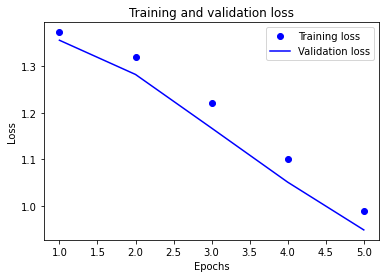

In [ ]:
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

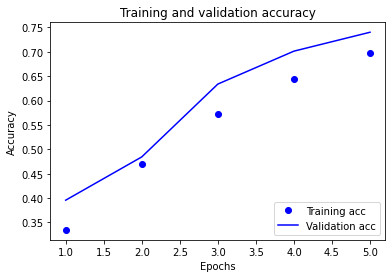

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()